# The solution for the Burger's Equation using the PINN model

1. First we import all the relevant classes and libraries

In [1]:
pip install pyDOE


Note: you may need to restart the kernel to use updated packages.


In [2]:
#from physicsinformed import PhysicsInformedBarModel
import scipy.io
from pyDOE import lhs
import utilities
import numpy as np
import torch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#dtype=torch.cfloat
dtype = torch.float
# Set seed for the Random Number Generator (RNG), setting the seed generates same set of random numbers everytime 
torch.manual_seed(10)
np.random.seed(10)

N_f = 20000
N0 = 500
N_b = 600
ub = np.array([1,1])
lb = np.array([0,-1])
X_ = lb + (ub - lb) * lhs(2, N_f)

tt = X_[:, 0:1]
xx = X_[:, 1:2]



id_f = np.random.choice(X_.shape[0], N_f, replace=False)
id_b = np.random.choice(X_.shape[0], N_f, replace=False)
id0 = np.random.choice(X_.shape[0], N0, replace=False)
idlb = np.random.choice(X_.shape[0], N_b, replace=False)
idub = np.random.choice(X_.shape[0], N_b, replace=False)



x = torch.tensor(xx[id_f,:], dtype=dtype, requires_grad=True, device=device)
t = torch.tensor(tt[id_f,:], dtype=dtype, requires_grad=True, device=device)
t0 = torch.tensor(tt[id0,:], dtype=dtype, requires_grad=True, device=device)
x0 = torch.tensor(xx[id0,:], dtype=dtype, requires_grad=True, device=device)
tlb = torch.tensor(tt[idlb,:], dtype=dtype, requires_grad=True, device=device)
xlb = torch.tensor(xx[idlb,:], dtype=dtype, requires_grad=True, device=device)
xub = torch.tensor(xx[idub,:], dtype=dtype, requires_grad=True, device=device)
tub = torch.tensor(tt[idub,:], dtype=dtype, requires_grad=True, device=device)

sech = lambda x: 1/torch.cosh(x)

In [4]:
#from physicsinformed import PhysicsInformedBarModel
import scipy.io
from pyDOE import lhs
import utilities
import numpy as np
import torch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#dtype=torch.cfloat
dtype = torch.float
# Set seed for the Random Number Generator (RNG), setting the seed generates same set of random numbers everytime 
torch.manual_seed(0)
np.random.seed(0)

N_f = 2000
N0 = 500
N_b = 600
ub = np.array([1,1])
lb = np.array([0,-1])
X_ = lb + (ub - lb) * lhs(2, N_f)

tt = X_[:, 0:1]
xx = X_[:, 1:2]
T, X = np.meshgrid(tt,xx)

X_star = np.hstack((T.flatten()[:,None],X.flatten()[:,None]))

id_f = np.random.choice(X_star.shape[0], N_f*10, replace=False)
id_b = np.random.choice(X_star.shape[0], N_f*10, replace=False)
id0 = np.random.choice(X_star.shape[0], N0, replace=False)
idlb = np.random.choice(X_star.shape[0], N_b, replace=False)
idub = np.random.choice(X_star.shape[0], N_b, replace=False)



x = torch.tensor(X_star[:, 1:2][id_f,:], dtype=dtype, requires_grad=True, device=device)
t = torch.tensor(X_star[:, 0:1][id_f,:], dtype=dtype, requires_grad=True, device=device)
t0 = torch.tensor(X_star[:, 0:1][id0,:], dtype=dtype, requires_grad=True, device=device)
x0 = torch.tensor(X_star[:, 1:2][id0,:], dtype=dtype, requires_grad=True, device=device)
tlb = torch.tensor(X_star[:, 0:1][idlb,:], dtype=dtype, requires_grad=True, device=device)
xlb = torch.tensor(X_star[:, 1:2][idlb,:], dtype=dtype, requires_grad=True, device=device)
xub = torch.tensor(X_star[:, 1:2][idub,:], dtype=dtype, requires_grad=True, device=device)
tub = torch.tensor(X_star[:, 0:1][idub,:], dtype=dtype, requires_grad=True, device=device)

sech = lambda x: 1/torch.cosh(x)

In [5]:
class PhysicsInformedBarModel:
    """A class used for the definition of Physics Informed Models for one dimensional bars."""

    def __init__(self,t0,x0,xub,tub,xlb,tlb, t,x,sech):
        """Construct a PhysicsInformedBar model"""
        
        
        self.t0 = t0*0
        self.x0 = x0
        self.xub = xub*0+1
        self.xlb = xlb*0-1
        self.t = t
        self.x = x
        self.tub = tub
        self.tlb = tlb
        self.sech = sech
        self.model = utilities.build_model(2,[20,20,20,20,20,20,20],1)
        self.differential_equation_loss_history = None
        self.boundary_condition_loss_history = None
        self.ini_condition_loss_history = None
        self.total_loss_history = None
        self.optimizer = None

    def get_displacements(self, t,x):
        """Get displacements."""

        u = self.model(torch.cat((t,x),1))   # predict

        return u

    def costFunction(self,t, x, u_pred):
        """Compute the cost function."""
        u_t = utilities.get_derivative(u_pred, t, 1).view(-1,1)
        u_x = utilities.get_derivative(u_pred, x,1)
        u_xx = utilities.get_derivative(u_pred, x,2)
        u_xlb = utilities.get_derivative(self.get_displacements(self.tlb,self.xlb), self.xlb,1)
        u_xub = utilities.get_derivative(self.get_displacements(self.tub,self.xub), self.xub,1)
        u_predlb = self.get_displacements(self.tlb,self.xlb)
        u_predub = self.get_displacements(self.tub,self.xub)
        u_x_lb = utilities.get_derivative(u_predlb , xlb,1)
        u_x_ub = utilities.get_derivative(u_predub , xub,1)
        i = 1j
        # Differential equation loss (f)
        differential_equation_loss = torch.mean((u_t+u_pred*u_x-(0.01/np.pi)*u_xx)**2)#torch.mean(((u_t*i+0.5*u_xx+u_pred*(u_pred.abs())).abs())**2)
        

        # Boundary condition loss initialization
       # boundary_condition_loss = 0

        # Sum over dirichlet and neumann boundary condition losses
        ini_condition_loss = torch.mean((self.get_displacements(self.t0,self.x0)+torch.sin(torch.pi*self.x0)) ** 2)
        boundary_condition_loss = torch.mean(u_predlb**2+u_predub**2)                                        
        #boundary_condition_loss += torch.mean(((self.get_displacements(self.t0,self.x0-2*self.sech(self.t0,self.x0))).abs()) ** 2).view(1)
        #boundary_condition_loss += torch.mean((u_predlb-u_predub).abs()) ** 2
        #boundary_condition_loss += torch.mean((( u_x_lb - u_x_ub) ** 2).abs()).view(1)

        return differential_equation_loss, boundary_condition_loss,ini_condition_loss

    def closure(self):
        """Calculation of training error and gradient"""
        self.optimizer.zero_grad()
        u_pred = self.get_displacements(self.t,self.x)
        loss = self.costFunction(self.t,self.x, u_pred)
        loss = loss[0] + loss[1] + loss[2]
        loss.backward(retain_graph=True)
        return loss

    def train(self, epochs, optimizer=None, **kwargs):
        """Train the model."""

        # Set optimizer
        if optimizer=='Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), **kwargs)
        
        elif optimizer=='LBFGS':
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), **kwargs)

        # Initialize history arrays
        self.differential_equation_loss_history = np.zeros(epochs)
        self.boundary_condition_loss_history = np.zeros(epochs)
        self.total_loss_history = np.zeros(epochs)
        self.ini_condition_loss_history =  np.zeros(epochs)
            
        # Training loop
        for i in range(epochs):
            # Predict displacements
            u_pred = self.get_displacements(self.t,self.x)

            # Cost function calculation
            differential_equation_loss, boundary_condition_loss,ini_condition_loss = self.costFunction(self.t,self.x, u_pred)

            # Total loss
            total_loss = differential_equation_loss + boundary_condition_loss +ini_condition_loss

            # Add energy values to history
            self.differential_equation_loss_history[i] += differential_equation_loss
            self.boundary_condition_loss_history[i] += boundary_condition_loss
            self.ini_condition_loss_history[i]+= ini_condition_loss
            self.total_loss_history[i] += total_loss

            # Print training state
            self.print_training_state(i, epochs)

            # Update parameters (Neural network train)
            self.optimizer.step(self.closure)

    def print_training_state(self, epoch, epochs, print_every=100):
        """Print the loss values of the current epoch in a training loop."""

        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            # Prepare string
            string = "Epoch: {}/{}\t\tDifferential equation loss = {:2f}\t\tBoundary condition loss = {:2f}\t\tTotal loss = {:2f}"

            # Format string and print
            print(string.format(epoch, epochs - 1, self.differential_equation_loss_history[epoch], self.boundary_condition_loss_history[epoch], self.total_loss_history[epoch]))
            print(self.ini_condition_loss_history[epoch])
    def plot_training_history(self, yscale='log'):
        """Plot the training history."""

        # Set up plot
        fig, ax = plt.subplots(figsize=(4,3))
        ax.set_title("Cost function history")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Cost function C")
        plt.yscale(yscale)

        # Plot data
        ax.plot(self.total_loss_history, 'k', linewidth=2, label="Total cost")
        ax.plot(self.differential_equation_loss_history, color='silver', linestyle='--', linewidth=2, label="Differential equation loss")
        ax.plot(self.boundary_condition_loss_history, color='r', linestyle='-.', linewidth=2, label="Boundary condition loss")
        

        ax.legend()
        fig.tight_layout()
        plt.show() 
        
        



In [6]:

u_t0 = lambda t,x: x*x*torch.cos(np.pi*x)

4. Next we generate the neural network model using the imported class PhysicsInformedBarModel

In [7]:
pinnModel = PhysicsInformedBarModel(t0,x0,xub,tub,xlb,tlb, t,x,sech)

check 7
check 7
check 7
check 7
check 7
check 7


5. Next we train our model. The method/function 'train' is defined in the class PhysicsInformedBarModel

In [8]:
epochs = 7000
learningRate = 1e-3

pinnModel.train(epochs, optimizer='Adam', lr=learningRate)

Epoch: 0/6999		Differential equation loss = 0.000007		Boundary condition loss = 0.012218		Total loss = 0.521141
0.5089167952537537
Epoch: 100/6999		Differential equation loss = 0.033858		Boundary condition loss = 0.037933		Total loss = 0.362647
0.29085564613342285
Epoch: 200/6999		Differential equation loss = 0.062712		Boundary condition loss = 0.007363		Total loss = 0.157015
0.08693952113389969
Epoch: 300/6999		Differential equation loss = 0.054262		Boundary condition loss = 0.009929		Total loss = 0.143058
0.07886682450771332
Epoch: 400/6999		Differential equation loss = 0.049167		Boundary condition loss = 0.005316		Total loss = 0.124803
0.07031945884227753
Epoch: 500/6999		Differential equation loss = 0.048270		Boundary condition loss = 0.002950		Total loss = 0.111301
0.06008085981011391
Epoch: 600/6999		Differential equation loss = 0.046891		Boundary condition loss = 0.001936		Total loss = 0.107113
0.05828654021024704
Epoch: 700/6999		Differential equation loss = 0.044091		Boundary 

Epoch: 6100/6999		Differential equation loss = 0.002301		Boundary condition loss = 0.000078		Total loss = 0.003944
0.0015650411369279027
Epoch: 6200/6999		Differential equation loss = 0.002213		Boundary condition loss = 0.000071		Total loss = 0.003795
0.0015110454987734556
Epoch: 6300/6999		Differential equation loss = 0.002187		Boundary condition loss = 0.000115		Total loss = 0.003781
0.001479058526456356
Epoch: 6400/6999		Differential equation loss = 0.002068		Boundary condition loss = 0.000069		Total loss = 0.003584
0.0014467790024355054
Epoch: 6500/6999		Differential equation loss = 0.002372		Boundary condition loss = 0.000093		Total loss = 0.003921
0.0014554901281371713
Epoch: 6600/6999		Differential equation loss = 0.001933		Boundary condition loss = 0.000067		Total loss = 0.003388
0.0013878336176276207
Epoch: 6700/6999		Differential equation loss = 0.002067		Boundary condition loss = 0.000088		Total loss = 0.003905
0.0017498171655461192
Epoch: 6800/6999		Differential equation lo

6. We generate sample test data using utilities library and then predict the displacements at those test points

Text(0.5, 1.0, '@ Time = 1')

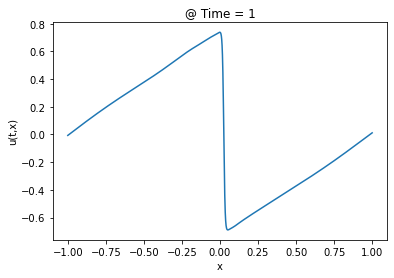

In [9]:
samples = 5000
X = []
t = utilities.generate_grid_1d(1,5000,0)
x = utilities.generate_grid_1d(2,5000,-1)
#x = torch.tensor(X_star[:, 1:2], dtype=dtype, requires_grad=True, device=device)
#t = torch.tensor(X_star[:, 0:1], dtype=dtype, requires_grad=True, device=device)
Time = 1
u_test = pinnModel.get_displacements(t*0+Time,x)
plt.plot(x.detach().numpy(),u_test.detach().numpy())
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('@ Time = 1')

7. We plot predicted displacements at test points and also the training history

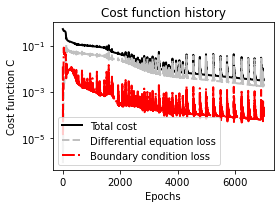

In [11]:
pinnModel.plot_training_history()
